# Whole-Sample-Image Model Dataset Template
This file is a template for a sample (ie not-real-data) pipeline which delivers whole images.

In [2]:
#@title Test Contexts
TEST_CONTEXTS=[
    "IMAGES",
    "DATASET",
    "MODEL_BUILD",
    "MODEL_INSTANTIATION"
]

########## Ground Truth ##########
organs = {b'ring_fill'}
# organs = {b'ring_fill', b'circle_border'}
# organs = {b'has_neighbors'}
onehot_key="organ"


# Startup


In [3]:
#!pip install keras

## Imports and GPU Management

In [4]:
%matplotlib inline

# Definition Modules
from abc import ABC, abstractmethod

# Operation Modules
import numpy as np
import tensorflow as tf
from tensorflow.python.types.core import TensorLike
from keras.layers.dense_attention import BaseDenseAttention

import math
from collections import OrderedDict
from collections.abc import Mapping
from itertools import chain

# Early Visualization Imports
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Quality-of-Life Functions

In [5]:
def smart_repr(key, value):
    if isinstance(value, tf.Tensor) and tf.size(value) <= 10:
      print(f"{key:20s}: {value.numpy()} @ {value.shape} / {value.dtype}")
    elif isinstance(value, OrderedDict):
      for dk, dv in value.items():
        smart_repr(f"{key}[{dk}]", dv)
    else:
      print(f"{key:20s}: [value] @ {value.shape} / {value.dtype}")

def simple_sample(ds, reply=False):
  for batch in ds.take(1):
    for key, value in batch.items():
      smart_repr(key, value)
    if reply:
      return batch

In [6]:
#@title ChannelDict
from typing import Callable, Tuple, Dict, List, Set, Iterable

class ChannelDict(OrderedDict):
  def _pack(self, to_pack:Iterable[TensorLike]) -> TensorLike:
    return tf.concat(list(to_pack), axis=-1)

  def shapes(self) -> Tuple[Set[tf.TensorShape], int]:
    total_channels=0
    get_shape = lambda t: tuple([*t.shape[:-1], None])
    shapes = set()
    for t in self.values():
      shapes.add(get_shape(t))
      total_channels += t.shape[-1]
    return shapes, total_channels

  def keychannels(self) -> 'OrderedDict[str, int]':
    return OrderedDict([(key, value.shape[-1]) for key, value in self.items()])

  def repack(self) -> 'Tuple[TensorLike, OrderedDict[str, int]]':
    repacked = self._pack(self.values())
    return repacked, self.keychannels()

  def packapply(self, fn:Callable[[TensorLike], TensorLike], keyfn:'Callable[[OrderedDict[str, int], OrderedDict[str,int]]]'=lambda x: x, *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
    repacked, keychannel_dict = self.repack()
    result = fn(repacked, *args, **kwargs)
    keychannel_updated = keyfn(keychannel_dict)
    return ChannelDict.resplit(result, keychannel_updated)
  
  def subset(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> 'ChannelDict':
    if ordered_keys is None and unordered_keys is None:
      raise ValueError("ChannelDict subset was given no keys to subset.")
    
    if ordered_keys is not None and unordered_keys is not None:
      raise ValueError("ChannelDict subset was given both ordered and unordered keys to subset - must only have one.")
    
    if ordered_keys is not None:
      return ChannelDict(**{key: self[key] for key in ordered_keys if key in self})
      # return self._pack([self[key] for key in ordered_keys if key in self])
    else:
      return ChannelDict(**{key: self[key] for key in self.keys() if ((key in unordered_keys) != invert)})
      # return self._pack([value for key, value in self.items() if key in unordered_keys])

  def partialpack(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> TensorLike:
    if ordered_keys is None and unordered_keys is None:
      raise ValueError("ChannelDict partialpack was given no keys to pack.")
    
    if ordered_keys is not None and unordered_keys is not None:
      raise ValueError("ChannelDict partialpack was given both ordered and unordered keys to pack - must only have one.")
    
    if ordered_keys is not None:
      return self._pack([self[key] for key in ordered_keys if key in self])
    else:
      return self._pack([value for key, value in self.items() if ((key in unordered_keys) != invert)])

  @staticmethod
  def resplit(packed_tensor:TensorLike, keys_channels:'OrderedDict[str, int]') -> 'ChannelDict[str, TensorLike]':
    split = ChannelDict()
    channel_idx = 0
    for key, channel_w in keys_channels.items():
      split[key] = packed_tensor[..., channel_idx:channel_idx+channel_w]
      channel_idx += channel_w
    return split

def split_data_to_x_y(data:'ChannelDict[str, TensorLike]') -> 'Tuple[ChannelDict[str, TensorLike], TensorLike]':
  return data.subset(unordered_keys={"target"}, invert=True), data["target"]

In [7]:
def imshow_c(im):
  imc = im.shape[-1]
  if imc == 1:
    plt.imshow(im[..., 0])
  elif imc <= 3:
    plt.imshow(tf.pad(im, [(0, 0), (0, 0), (0, 3-imc)]))
  elif len(im.shape) == 2:
    plt.imshow(im)
  else:
    raise NotImplementedError("imshow_c can't show more-than-3-channel images")

# Dataset Pipeline
`construct_spatial_dataset() -> tf.data.Dataset[ChannelDict]`

## Image and Metadata Origination
`make_pretransformed_images_dataset() -> tf.data.Dataset[OrderedDict[str, [str, float, int[2], ChannelDict]]`

### Hyperparameters

In [8]:
#@title RandomSample HyperParameters
########### ALL IMAGES #################
organs_l = list(organs)
SIZE_MIN,    SIZE_MAX    = 250, 300
PX_SIZE_MIN, PX_SIZE_MAX = 0.004, .008

########### RINGS ######################
NUM_RINGS = 60
# NUM_RINGS = 2

RING_MIN_R1_THICKNESS = [[0.05], [0.03]]
RING_MAX_R1_THICKNESS = [[0.075], [0.045]]

RING_BLEND_RADIUS = 0.001
RING_BLEND_RADIUS_INV = 1.0/RING_BLEND_RADIUS

### Unitized Ruling Functions

In [9]:
@tf.function
def make_unitized_rulers(img_w_h, pixel_size):
  xy_virtual_size = tf.cast(img_w_h, tf.float32)*tf.expand_dims(tf.cast(pixel_size, tf.float32), axis=-1)
  h_ruler = tf.linspace(0.0, xy_virtual_size[0], img_w_h[0])
  v_ruler = tf.linspace(0.0, xy_virtual_size[1], img_w_h[1])
  return [h_ruler, v_ruler], xy_virtual_size

@tf.function
def make_unitized_meshgrid(img_w_h, pixel_size):
  [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

  H, V = tf.meshgrid(h_ruler, v_ruler)
  return tf.stack([H, V]), xy_virtual_size

### Pattern Constructors

In [10]:
@tf.function
def ring_inner_outer(img_w_h, pixel_size):
    [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

    # rings_x, rings_y          = tf.random.uniform([2, NUM_RINGS], minval=[[0], [0]],            maxval=tf.expand_dims(xy_virtual_size, axis=-1))
    rings_xy = tf.random.uniform([2, NUM_RINGS], minval=[[0], [0]],            maxval=tf.expand_dims(xy_virtual_size, axis=-1))
    # rings_r1, rings_thickness = tf.random.uniform([2, NUM_RINGS], minval=RING_MIN_R1_THICKNESS, maxval=RING_MAX_R1_THICKNESS)
    rings_r1_t = tf.random.uniform([2, NUM_RINGS], minval=RING_MIN_R1_THICKNESS, maxval=RING_MAX_R1_THICKNESS)
    rings_r1 = rings_r1_t[0]
    rings_r2 = tf.reduce_sum(rings_r1_t, axis=0)


    xr = tf.abs(h_ruler[:, None] - rings_xy[0, None, :])
    yr = tf.abs(v_ruler[:, None] - rings_xy[1, None, :])
    # print(xr.shape)

    rr = tf.math.sqrt(tf.math.square(xr)[None, :, :] + tf.math.square(yr)[:, None, :])
    # print(rr.shape)

    k1 = rings_r1 - rr + RING_BLEND_RADIUS
    k2 = rings_r2 - rr + RING_BLEND_RADIUS
    # print(k1.shape, k2.shape)

    m1 = tf.maximum(0.0, tf.minimum(1.0, k1*RING_BLEND_RADIUS_INV*0.5))
    m2 = tf.maximum(0.0, tf.minimum(1.0, k2*RING_BLEND_RADIUS_INV*0.5))
    m2 = m2-m1
    m1 = tf.reduce_max(m1, axis=-1, keepdims=True)
    m2 = tf.reduce_max(m2, axis=-1, keepdims=True)

    m2 = tf.maximum(0.0, m2-(m1*100)); print("WARNING! ring_inner_outer is TOTALLY CHEATING!")
    return m1, m2


def make_ring_fill(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = inner, source=outer)

def make_circle_border(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = outer, source=inner)

### Sample and Dataset sources

In [11]:
constructor_lookup = {
    b"ring_fill": make_ring_fill,
    b"circle_border": make_circle_border,
}

@tf.function
def construct_sample_around_constructor(constructor_title, constructor_fn):
    print("Constructing new sample...")
    img_w_h = tf.random.uniform((2,), minval=SIZE_MIN, maxval=SIZE_MAX, dtype=tf.int32)
    pixel_size = tf.random.uniform((), minval=PX_SIZE_MIN, maxval=PX_SIZE_MAX, dtype=tf.float32)
    operation = constructor_title

    # Construct spatial data
    spatial_data = constructor_fn(img_w_h, pixel_size)

    return OrderedDict([
                        (onehot_key, operation),
                        ("pixel_size", pixel_size),
                        ("img_w_h", img_w_h),
                        ("spatial_data", spatial_data)
    ])


@tf.function
def make_dataset_around_constructor(constructor_title, constructor_fn):
  return tf.data.Dataset.random().map(lambda d: construct_sample_around_constructor(constructor_title, constructor_fn))

@tf.function
def make_all_construction_datasets():
  return [make_dataset_around_constructor(k, constructor_lookup[k]) for k in organs_l]

@tf.function
def make_pretransformed_images_dataset():
  return tf.data.Dataset.sample_from_datasets(make_all_construction_datasets())


### Tests

TESTING RING FILL EXAMPLE DATA
WARNING! ring_inner_outer is TOTALLY CHEATING!
Observed coverage: 0.748659
Upper bound on circle coverage: 2.714336052701581


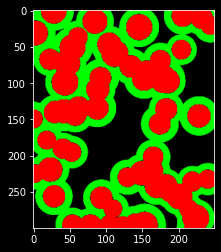

In [12]:
if "IMAGES" in TEST_CONTEXTS:
    print("TESTING RING FILL EXAMPLE DATA")
    ring_fill_sample = make_ring_fill([SIZE_MIN, SIZE_MAX], PX_SIZE_MIN)
    ring_fill_tensor, _ = ring_fill_sample.repack()
    imshow_c(ring_fill_tensor)
    print("Observed coverage:", tf.reduce_sum(tf.reduce_mean(ring_fill_tensor, axis=[0, 1])).numpy())
    upper_bound_circle_area = np.pi * (np.sum(RING_MAX_R1_THICKNESS)**2 * NUM_RINGS)
    lower_bound_image_area = (SIZE_MIN*PX_SIZE_MIN) ** 2

    upper_bound_circle_fraction = upper_bound_circle_area / lower_bound_image_area
    print(f"Upper bound on circle coverage:", upper_bound_circle_fraction)

Constructing new sample...
WARNING! ring_inner_outer is TOTALLY CHEATING!
organ               : b'ring_fill' @ () / <dtype: 'string'>
pixel_size          : 0.006194201298058033 @ () / <dtype: 'float32'>
img_w_h             : [254 273] @ (2,) / <dtype: 'int32'>
spatial_data[target]: [value] @ (273, 254, 1) / <dtype: 'float32'>
spatial_data[source]: [value] @ (273, 254, 1) / <dtype: 'float32'>


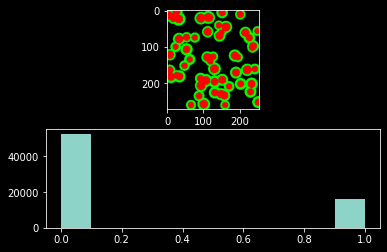

In [13]:
if "IMAGES" in TEST_CONTEXTS:
    ptim_ds_test = make_pretransformed_images_dataset()
    ptim_sample = simple_sample(ptim_ds_test, reply=True)
    ptim_sample_spatial, _ = ptim_sample["spatial_data"].repack()
    fig, ax = plt.subplots(2)
    ax[0].imshow(tf.pad(ptim_sample_spatial, [(0, 0), (0, 0), (0, 1)]), vmin=0, vmax=1)
    ax[1].hist(tf.reshape(ptim_sample_spatial[..., 0], (-1)))

## Spatial Information Construction
`construct_spatial_dataset = lambda: make_pretransformed_images_dataset().map(build_spatial_data).batch(DATASET_BATCH_N)`

### Dataset Hyperparameters


In [14]:
#@title Dataset Hyperparameters

TARGET_CHANNELS = 1
SRC_IM_CHANNELS = 1
CATEGORY_1HOT_D = len(organs)


########## Embedding spatial information ##########
EMBED_UM_PER_PX = True
NUM_UM_PER_PX_C = 1 if EMBED_UM_PER_PX else 0

USE_ORIGINAL_XY = False
ORIGINAL_XY_CHN = 2 if USE_ORIGINAL_XY else 0

SINE_ANNOTATION = False and USE_ORIGINAL_XY
SIN_FREQUENCIES = [0.1, 1, 10]
SINE_ANNOTATE_N = 2*len(SIN_FREQUENCIES) if SINE_ANNOTATION else 0

USE_CENTER_DIST = False and USE_ORIGINAL_XY
CENTER_DIST_CHN = 1 if USE_CENTER_DIST else 0

########## Annotation Summary ##########
# The annotated image dims will be:
# [width, height, ORIGINAL_XY_CHN + TARGET_CHANNELS + SRC_IM_CHANNELS + CATEGORY_1HOT_D + SINE_ANNOTATE_N + CENTER_DIST_CHN]
SOURCE_CHANNELS = SRC_IM_CHANNELS + CATEGORY_1HOT_D + NUM_UM_PER_PX_C + SINE_ANNOTATE_N + CENTER_DIST_CHN # Channels which will be fed as the source data to the model
PREPRO_CHANNELS = ORIGINAL_XY_CHN + TARGET_CHANNELS + SOURCE_CHANNELS                   # Total channels coming off the annotation pipeline

########## Delivery Parameters ##########
DATASET_BATCH_N = 1
PREPRO_DOWNSIZE = 1

### Construct fullsize image spatial data

In [15]:
@tf.function
def compute_original_coordinates(img_w_h, pixel_size):
  um_wh_2 = (tf.cast(img_w_h, tf.float32)*tf.expand_dims(pixel_size, axis=-1))/2.0
  h_ruler = tf.linspace(-um_wh_2[0], um_wh_2[0], img_w_h[0])
  v_ruler = tf.linspace(-um_wh_2[1], um_wh_2[1], img_w_h[1])
  XY = tf.stack(tf.meshgrid(h_ruler, v_ruler), axis=-1)

  return XY

In [16]:
@tf.function
def compute_center_distance(XY):
  XYSquaredSum = tf.reduce_sum(tf.math.square(XY), axis=-1)
  DistFromCenter = tf.math.sqrt(
    tf.reduce_sum(
        tf.math.square(XY), 
        axis=-1,
        keepdims=True
    )
  )
  return DistFromCenter

@tf.function
def compute_sine_rulers(XY, sin_frequencies=SIN_FREQUENCIES):
  return tf.concat([0.5 + 0.5*tf.math.sin(XY * math.pi * 2 * freq) for freq in sin_frequencies], axis=-1)

In [17]:
def tile_vector_to_size(vector, size):
    tiled = tf.tile(tf.reshape(vector, [1, 1, -1]), tf.concat([size[..., ::-1], [1]], axis=-1))
    if hasattr(vector, "shape") and len(vector.shape):
        print(f"Vector {vector} has shape {vector.shape}")
        return tf.ensure_shape(tiled, [None, None, vector.shape[-1]])
    else:
        return tf.ensure_shape(tiled, [None, None, 1])

In [18]:
# @tf.function # I wish this would work as a tf.function, but somehow it can't find an object's __repr__, so I'm leaving it this way.
def compute_onehots(input, multiples, categories=organs):
    onehot = tf.cast(tf.stack([tf.equal(input, s) for s in categories], axis=-1), dtype=tf.float32)
    onehot = tile_vector_to_size(onehot, multiples)
    return onehot

In [19]:
@tf.function
def resize_spatial_data(spatial_data, img_w_h, prepro_downsize=PREPRO_DOWNSIZE, **kwargs):
  output_shapes = tf.cast(
    tf.cast(img_w_h, tf.float32) * prepro_downsize,
    tf.int32
  )
  return tf.image.resize(spatial_data, output_shapes, preserve_aspect_ratio=True)

In [20]:
def build_spatial_data(d, onehot_key=onehot_key, embed_um_per_px=EMBED_UM_PER_PX, use_original_xy=USE_ORIGINAL_XY, use_center_dist=USE_CENTER_DIST, sine_annotation=SINE_ANNOTATION):
  ######### Embed Data
  spatial_d = d["spatial_data"]

  img_w_h    = d.pop("img_w_h")
  pixel_size = d.pop("pixel_size")
  onehot     = d.pop(onehot_key)

  spatial_d[onehot_key] = compute_onehots(onehot, img_w_h)
  print("Organs Shape:", spatial_d[onehot_key].shape)


  if embed_um_per_px:
      spatial_d["pixel_size"] = tile_vector_to_size(pixel_size, img_w_h)
      print("PX Size Shape:", spatial_d["pixel_size"].shape)

  if use_original_xy:
    XY = compute_original_coordinates(img_w_h, pixel_size)
    spatial_d["XY"] = XY

    if use_center_dist:
      spatial_d["center_dist"] = compute_center_distance(XY)
    if sine_annotation:
      spatial_d["sine_annotation"] = compute_sine_rulers(XY)
  
  ########## Do Resizing
  resized_spatial_d = spatial_d.packapply(lambda t: resize_spatial_data(t, img_w_h))
  return resized_spatial_d

In [21]:
construct_spatial_dataset = lambda: make_pretransformed_images_dataset().map(build_spatial_data).batch(DATASET_BATCH_N)

## Pipeline Test

Vector Tensor("Cast:0", shape=(1,), dtype=float32) has shape (1,)
Organs Shape: (None, None, 1)
PX Size Shape: (None, None, 1)
Dataset Sample Shape and Channels: (1, 225, 250, 4) OrderedDict([('target', 1), ('source', 1), ('organ', 1), ('pixel_size', 1)])


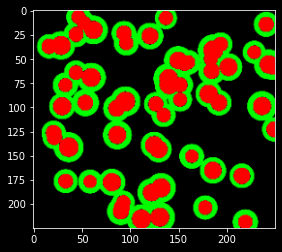

In [22]:
if "DATASET" in TEST_CONTEXTS:
    ds_sample = ChannelDict(next(iter(construct_spatial_dataset())))
    p, d = ds_sample.repack()
    print("Dataset Sample Shape and Channels:", p.shape, d)
    imshow_c(ds_sample.partialpack(unordered_keys={"target", "source"})[0])